In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from backtesting import Backtest, Strategy
from scipy.stats import spearmanr
import argparse
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
import os

cwd = os.getcwd()
print("Current working directory:", cwd)


Current working directory: /Users/q/Code/venv/Web Mining/5_Evaluation


In [3]:
import pandas as pd


df_vix = pd.read_csv("../2_data/daily_vix.csv", parse_dates=["date"])
df_nvda = pd.read_csv("../2_data/daily_nvda.csv", parse_dates=["Date"]).rename(columns={"Date": "date"})
df_sentiscores = pd.read_csv("../2_data/daily_sentiment_bert.csv", parse_dates=["date"])
# choose the date range
start_date = "2017-02-28"
end_date = "2022-02-28"
date_range = pd.date_range(start=start_date, end=end_date)
df_all = pd.DataFrame({"date": date_range})

# add prefix: VIX
df_vix = df_vix[df_vix["date"].between(start_date, end_date)]
df_vix = df_vix.rename(columns=lambda x: f"vix_{x}" if x != "date" else x)

# add prefix: NVDA
df_nvda.columns = [col.lower() for col in df_nvda.columns]
df_nvda = df_nvda[df_nvda["date"].between(start_date, end_date)]
df_nvda = df_nvda.rename(columns=lambda x: f"nvda_{x}" if x != "date" else x)

# also filter the date range
df_sentiscores = df_sentiscores[df_sentiscores["date"].between(start_date, end_date)]

# merge the data
df_merged = df_all.merge(df_sentiscores, on="date", how="left") \
                  .merge(df_vix, on="date", how="left") \
                  .merge(df_nvda, on="date", how="left")

# check the missing values
print("Missing values per column:")
print(df_merged.isnull().sum())

# check the merged data
print(df_merged.head())

# save the result
df_merged.to_csv("factor_data.csv", index=False)

Missing values per column:
date                     0
avg_sentiment_score      0
model_type               0
vix_open               567
vix_high               567
vix_low                567
vix_close              567
nvda_open              780
nvda_high              780
nvda_low               780
nvda_close             780
nvda_volume            780
dtype: int64
        date  avg_sentiment_score    model_type  vix_open  vix_high  vix_low  \
0 2017-02-28            -0.029851  FinBERT+BERT     12.19     12.96    12.13   
1 2017-03-01             0.075949  FinBERT+BERT     12.31     12.58    11.78   
2 2017-03-02             0.187500  FinBERT+BERT     12.43     12.71    11.32   
3 2017-03-03             0.014925  FinBERT+BERT     11.96     11.97    10.94   
4 2017-03-04            -0.142857  FinBERT+BERT       NaN       NaN      NaN   

   vix_close  nvda_open  nvda_high  nvda_low  nvda_close  nvda_volume  
0      12.92        NaN        NaN       NaN         NaN          NaN  
1      12.5

In [4]:
# 1. preprocess the data
def preprocess_data(df):
    # make sure the date column exists
    if 'date' not in df.columns:
        raise ValueError("data must contain the 'date' column")
    
    # set the date index
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    # handle the missing values
    df.ffill(inplace=True)
    df.dropna(inplace=True)
    
    # calculate the future return and technical factors
    df['future_5d_ret'] = df['nvda_close'].pct_change(5).shift(-5)
    df['nvda_momentum'] = df['nvda_close'].pct_change(5)
    df['nvda_volatility'] = df['nvda_close'].pct_change().rolling(5).std()
    df['nvda_volume_change'] = df['nvda_volume'].pct_change(5)
    df['volatility_20'] = df['nvda_close'].pct_change().rolling(20).std()

    
    return df

# 2. factor construction
def build_enhanced_factors(df):
    """
    improved factor construction:
    1. non-linear processing of sentiment factor
    2. VIX term structure
    3. PCA dimensionality reduction of technical factors
    """
    factors = df.copy()
    
    # 1. sentiment factor
    sentiment_threshold = factors['avg_sentiment_score'].std() * 1.5
    factors['sentiment_factor'] = np.where(
        factors['avg_sentiment_score'].abs() > sentiment_threshold,
        np.sign(factors['avg_sentiment_score']),  # only keep the direction
        0
    )
    
    # 2. VIX term structure factor (near-month - 3-month average)
    factors['vix_structure'] = factors['vix_close'] - factors['vix_close'].rolling(63).mean()
    factors['vix_factor'] = StandardScaler().fit_transform(factors[['vix_structure']])
    
    # 3. PCA dimensionality reduction of technical factors (remove redundancy)
    tech_factors = factors[['nvda_momentum', 'nvda_volatility', 'nvda_volume_change']].dropna()
    pca = PCA(n_components=1)
    factors.loc[tech_factors.index, 'tech_factor'] = pca.fit_transform(
        StandardScaler().fit_transform(tech_factors))
    
    return factors

# 3. build the composite index
def build_composite_index(factors_df):
    # select the factor columns
    factor_cols = ['sentiment_factor', 'vix_factor', 'tech_factor']
    
    # standardize the factors
    factors_standardized = factors_df[factor_cols].apply(
        lambda x: (x - x.rolling(60).mean()) / x.rolling(60).std()
    )
    
    composite_index = factors_standardized.mean(axis=1)
    return composite_index

# 4. factor analysis
def analyze_factors(factors_df, composite_index):
    # factor correlation
    corr_matrix = factors_df[['sentiment_factor', 'vix_factor', 'tech_factor']].corr()
    print("factor correlation:\n", corr_matrix)
    
    # factor analysis with future return
    def calculate_ic(factor, ret, lag=5):
        valid_idx = ~pd.isna(factor) & ~pd.isna(ret)
        return spearmanr(factor[valid_idx], ret[valid_idx]).correlation
    
    ic_results = {
        'sentiment': calculate_ic(factors_df['sentiment_factor'], factors_df['future_5d_ret']),
        'vix': calculate_ic(factors_df['vix_factor'], factors_df['future_5d_ret']),
        'tech': calculate_ic(factors_df['tech_factor'], factors_df['future_5d_ret'])
    }
    print("\nfactor IC value (5-day return):", ic_results)
    
    # visualize the composite index
    plt.figure(figsize=(12, 6))
    composite_index.plot(title='Composite Index')
    plt.axhline(0, color='gray', linestyle='--')
    plt.show()

# 5. enhanced backtest strategy
class EnhancedCompositeStrategy(Strategy):
    ma_short = 30
    ma_long = 50
    volatility_threshold = 0.015
    confirm_window = 3
    stop_loss_pct = 0.03
    take_profit_pct = 0.05

    def init(self):
        self.composite_index = self.data.composite_index
        self.volatility = self.data.volatility_20

        self.ma_short_series = self.I(lambda: pd.Series(self.composite_index).rolling(self.ma_short).mean().to_numpy())
        self.ma_long_series = self.I(lambda: pd.Series(self.composite_index).rolling(self.ma_long).mean().to_numpy())

        self.signal = self.I(self._generate_signals, name="Signal")

    def _generate_signals(self):
        index = pd.Series(self.composite_index, index=self.data.index)
        
        signals = pd.Series(0.0, index=index.index)
        
        # condition 1: index crosses the moving average
        cond1 = (self.ma_short_series > self.ma_long_series)
    
        # condition 2: composite index is above 0 (multiple factors are bullish)
        cond2 = index > 0
    
        # condition 3: volatility is below the threshold
        cond3 = self.volatility < self.volatility_threshold
    
        # combined signal: all conditions must be met for 3 consecutive days to buy
        buy_signal = (cond1 & cond2 & cond3).rolling(self.confirm_window).sum() == self.confirm_window
    
        signals[buy_signal] = 1.0
    
        return signals

    def next(self):
        if not self.signal[-1]:
            return

        try:
            # if not holding, buy
            if not self.position:
                self.buy(size=1)

            # if holding, judge take profit/stop loss
            elif self.position:
                current_price = self.data.Close[-1]
                try:
                    entry_price = self.trades[-1].entry_price
                except:
                    print("[warning] cannot get the entry price, skip take profit/stop loss judgment")
                    return
            
                if current_price >= entry_price * (1 + self.take_profit_pct) or \
                   current_price <= entry_price * (1 - self.stop_loss_pct):
                    print(f"take profit/stop loss triggered, current price: {current_price}, entry price: {entry_price}")
                    self.position.close()
        except Exception as e:
            print(f"[error] cannot execute the transaction: {str(e)}")

In [5]:
# Visualization

def plot_factor_vs_price(df, composite_index):
    plt.figure(figsize=(14, 7))
    
    # left axis: price
    ax1 = plt.gca()
    ax1.plot(df.index, df['nvda_close'], color='tab:blue', label='NVDA Price')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.tick_params(axis='y', colors='tab:blue')
    
    # right axis: composite index
    ax2 = ax1.twinx()
    ax2.plot(df.index, composite_index, color='tab:orange', alpha=0.7, label='Composite Index')
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax2.set_ylabel('Composite Index', color='tab:orange')
    ax2.tick_params(axis='y', colors='tab:orange')
    
    # mark the trading signals (need to run backtest first)
    if 'signal' in df.columns:
        buy_signals = df[df['signal'] == 1]
        sell_signals = df[df['signal'] == -1]
        ax1.scatter(buy_signals.index, buy_signals['nvda_close'], 
                   color='green', marker='^', alpha=1, label='Buy')
        ax1.scatter(sell_signals.index, sell_signals['nvda_close'],
                   color='red', marker='v', alpha=1, label='Sell')
        
    if 'ci_ma' in df.columns:
        ax2.plot(df.index, df['ci_ma'], color='tab:red', linestyle='--', label='Composite Index MA')
        
        plt.title('Composite Index vs NVDA Price with Trading Signals')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.show()

def plot_factor_correlation(factors_df):
    plt.figure(figsize=(8, 6))
    corr = factors_df[['sentiment_factor', 'vix_factor', 'tech_factor']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Factor Correlation Matrix')
    plt.show()

def plot_factor_group_returns(factors_df):
    # directly use the original binary grouping
    group_returns = factors_df.groupby('sentiment_factor')['future_5d_ret'].mean()
    
    # rename the labels
    group_returns.index = ['Negative(-1)', 'Neutral(0)', 'Positive(1)']
    
    plt.figure(figsize=(10, 5))
    colors = ['red', 'gray', 'green']
    group_returns.plot(kind='bar', color=colors)
    
    # add the statistical significance mark
    for i, v in enumerate(group_returns):
        plt.text(i, v, f"{v:.2%}", ha='center', va='bottom')
    
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title('Future 5-Day Returns by Sentiment Direction')
    plt.ylabel('Mean Return')
    plt.xlabel('Sentiment Group')
    plt.xticks(rotation=0)
    plt.show()

def enhanced_backtest_plots(returns, benchmark_returns):
    """
    plot the cumulative return comparison between the strategy and the benchmark.
    
    parameters:
    - returns: strategy daily return (Series)
    - benchmark_returns: benchmark daily return (Series)
    """

    # align the two sequences
    combined = pd.DataFrame({
        'strategy': returns,
        'benchmark': benchmark_returns
    }).dropna()

    # cumulative return
    cumulative = (1 + combined).cumprod()
    for year in pd.to_datetime(cumulative.index).year.unique():
        plt.axvline(pd.Timestamp(f'{year}-01-01'), color='gray', linestyle=':', alpha=0.3)
    sharpe = returns.mean() / returns.std() * np.sqrt(252)

    # plot
    plt.figure(figsize=(12, 6))   
    plt.text(0.02, 0.95, f'Sharpe: {sharpe:.2f}', transform=plt.gca().transAxes,fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    plt.plot(cumulative.index, cumulative['strategy'], label='Strategy', linewidth=2)
    plt.plot(cumulative.index, cumulative['benchmark'], label='Benchmark', linestyle='--', linewidth=2)
    plt.title('Cumulative Returns: Strategy vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

original data shape: (1827, 12)
preprocessed data shape: (1519, 16)

generate factor analysis visualization...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


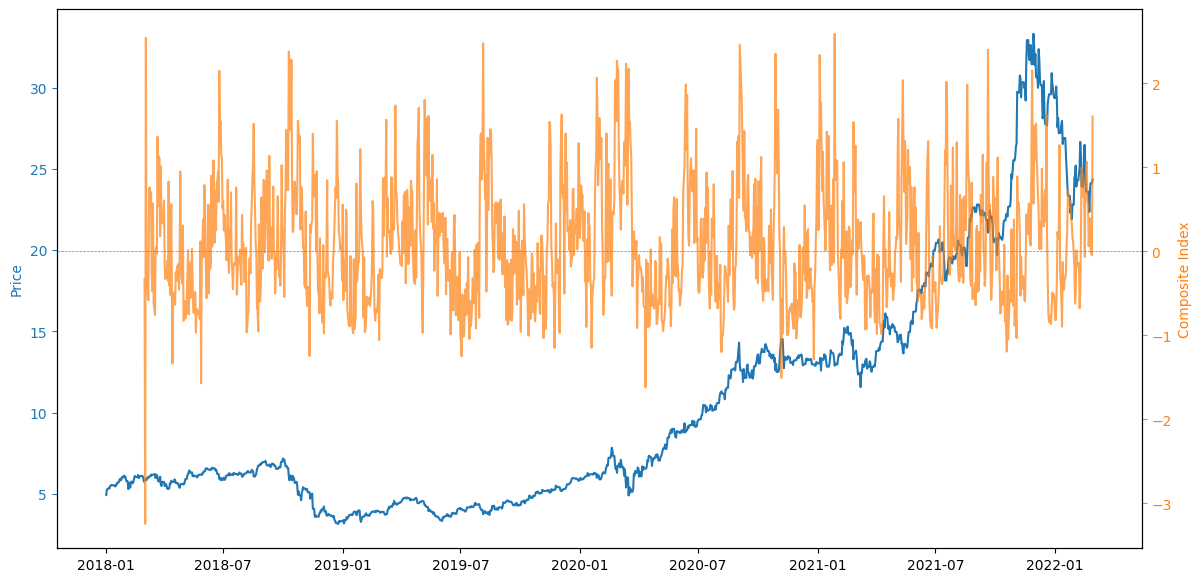

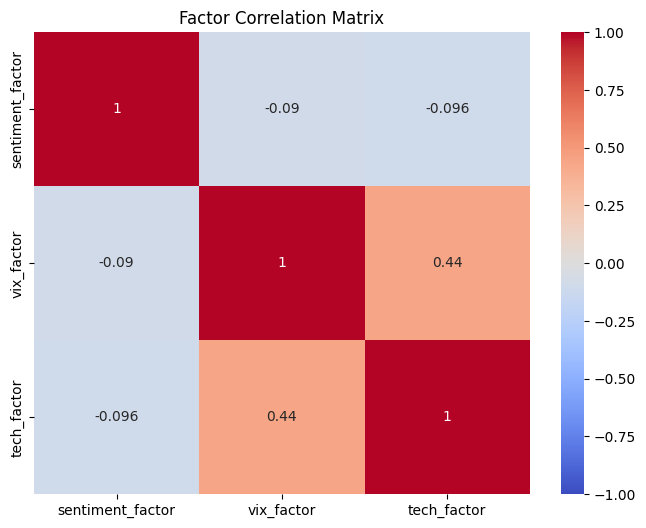

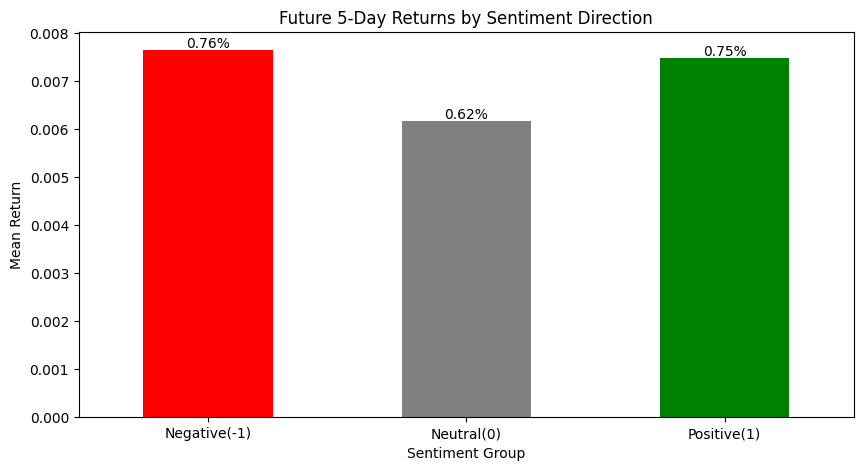


running backtest...


Backtest.run:   0%|          | 0/1410 [00:00<?, ?bar/s]

take profit/stop loss triggered, current price: 6.36601, entry price: 6.5681
take profit/stop loss triggered, current price: 5.92055, entry price: 6.21352
take profit/stop loss triggered, current price: 6.64427, entry price: 5.99187
take profit/stop loss triggered, current price: 4.67193, entry price: 6.78686
take profit/stop loss triggered, current price: 5.28102, entry price: 4.64927
take profit/stop loss triggered, current price: 5.97288, entry price: 5.6833
take profit/stop loss triggered, current price: 13.0216, entry price: 5.87724
take profit/stop loss triggered, current price: 19.9113, entry price: 13.0216
Start                     2018-01-02 00:00:00
End                       2022-02-28 00:00:00
Duration                   1518 days 00:00:00
Exposure Time [%]                    74.19355
Equity Final [$]                   10017.8506
Equity Peak [$]                    10026.8221
Commissions [$]                       0.06129
Return [%]                            0.17851
Buy & Hold

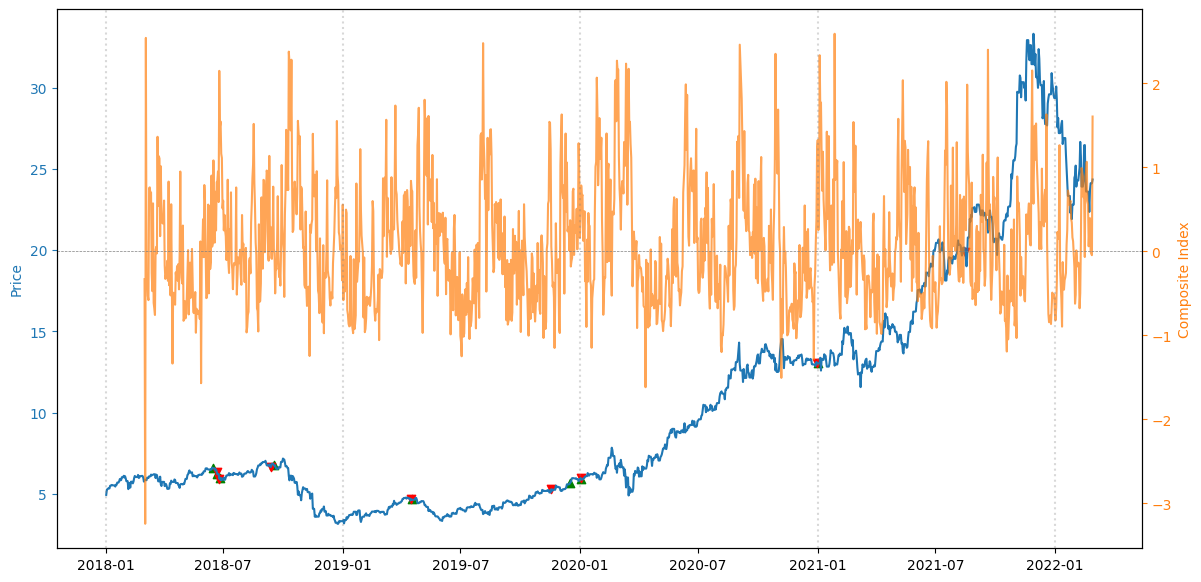

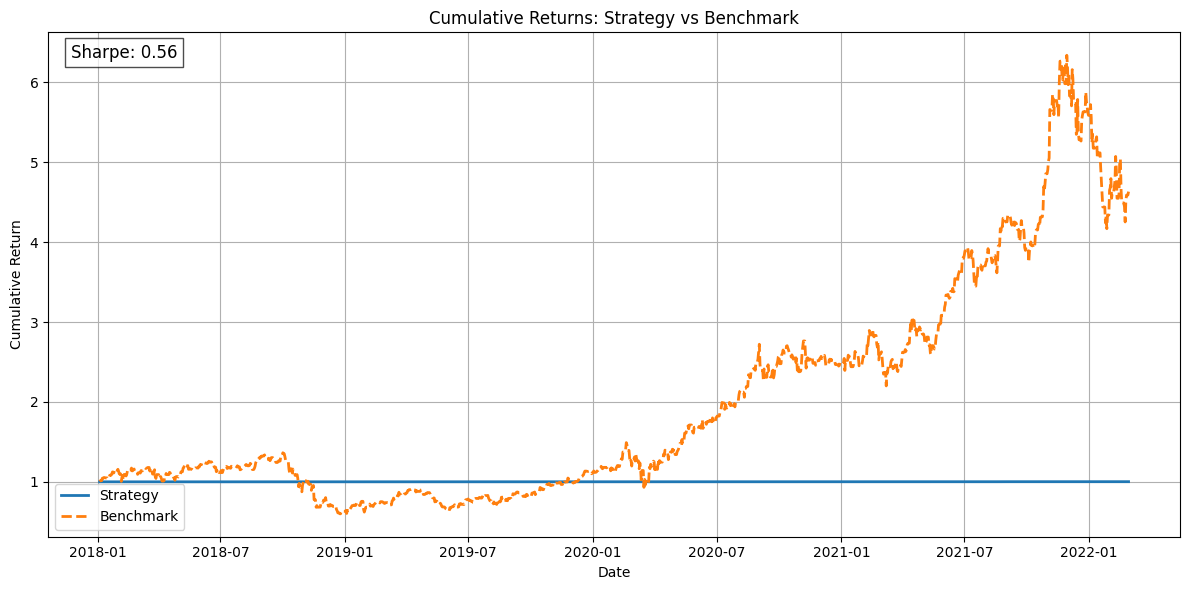

In [6]:
def main():
    try:
        # 1. load data
        df = pd.read_csv('factor_data.csv')
        print("original data shape:", df.shape)
        
        # 2. preprocess
        df = preprocess_data(df)
        print("preprocessed data shape:", df.shape)
        
        # 3. build factors
        factors = build_enhanced_factors(df)
        
        # 4. composite index
        factors['composite_index'] = build_composite_index(factors)
        df['composite_index'] = factors['composite_index']
        backtest_data = df[['nvda_open', 'nvda_high', 'nvda_low', 'nvda_close', 'volatility_20', 'composite_index']].copy()
        # ========== generate factor analysis visualization ==========
        print("\ngenerate factor analysis visualization...")
        # factor vs price
        plot_factor_vs_price(factors, factors['composite_index'])
        
        # factor correlation
        plot_factor_correlation(factors)
        
        # factor group returns
        plot_factor_group_returns(factors)
        
         # 5. backtest preparation
        backtest_data = df[['nvda_open', 'nvda_high', 'nvda_low', 'nvda_close',  # OHLC data
        'volatility_20','composite_index' ]].copy()
        backtest_data.columns = ['Open', 'High', 'Low', 'Close', 'volatility_20',  
        'composite_index']
        backtest_data['composite_index'] = factors['composite_index']  # 添加composite_index列
        backtest_data.dropna()

        # 6. running backtest
        print("\nrunning backtest...")
        bt = Backtest(backtest_data, EnhancedCompositeStrategy, commission=0.0005, trade_on_close=True)
        results = bt.run()
        print(results)
        
        # mark the trading signals
        factors['signal'] = 0
        if hasattr(results, '_trades') and results._trades is not None:
            print(f"generate {len(results._trades)} trades")
            
            # ensure date conversion and normalization (remove time)
            entry_dates = pd.to_datetime(results._trades['EntryTime']).dt.normalize()
            exit_dates = pd.to_datetime(results._trades['ExitTime']).dt.normalize()
            
            # convert to date string format to match the index
            entry_dates = entry_dates.dt.strftime('%Y-%m-%d')
            exit_dates = exit_dates.dt.strftime('%Y-%m-%d')
            
            factors['signal'] = 0
            factors.loc[factors.index.strftime('%Y-%m-%d').isin(entry_dates), 'signal'] = 1
            factors.loc[factors.index.strftime('%Y-%m-%d').isin(exit_dates), 'signal'] = -1
        else:
            print("warning: no trades generated")
        
        # factor vs price with trading signals
        plot_factor_vs_price(factors, factors['composite_index'])
        
        # daily returns
        equity_curve = results['_equity_curve']  
        returns = equity_curve['Equity'].pct_change().dropna()
        
        # benchmark daily returns
        benchmark_returns = df['nvda_close'].loc[returns.index].pct_change().dropna()
        
        # call the visualization function
        enhanced_backtest_plots(returns, benchmark_returns)
        
    except Exception as e:
        print(f"error: {str(e)}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()

- sentiment, VIX, and tech factors are largely independent, with weak direct correlation to price.

- Both positive and negative sentiment groups show slightly higher future returns than neutral, but the difference is small.

- The backtest strategy underperforms the buy-and-hold benchmark by a large margin, indicating that the current factor or signal construction has limited trading value. Further optimization of factor design or signal generation is recommended.